In [22]:
# Benchmark Datasets

from benchmark import Benchmark

df = Benchmark.load_benchmark_dataset(Benchmark.datasets_names[0])

In [16]:
# HTRU2 Dataset

# import pandas as pd

# column_names = ["ip_mean", "ip_std", "ip_excess_curtosis", "ip_skewness", "dmsnr_mean", "dmsnr_std", "dmsnr_excess_curtosis", "dmsnr_skewness", "target"]
# df = pd.read_csv("../data/HTRU2/HTRU_2.csv", header=None, names=column_names)


In [23]:
# Describe Dataset

import pandas as pd

def describe_dataset(dataset: pd.DataFrame) -> None:
    print(50*"-")
    print(f"General statistics: \n{df.describe()}")
    print(f"Columns types: \n{df.dtypes}")
    print(f"Number of samples: \n{len(df)}")
    print(f"Classes distribution: \n{df['target'].value_counts()}")
    print(50*"-")

describe_dataset(df)

--------------------------------------------------
General statistics: 
                0           1           2           3           4           5  \
count  336.000000  336.000000  336.000000  336.000000  336.000000  336.000000   
mean     0.500060    0.500000    0.495476    0.501488    0.500030    0.500179   
std      0.194634    0.148157    0.088495    0.027277    0.122376    0.215751   
min      0.000000    0.160000    0.480000    0.500000    0.000000    0.030000   
25%      0.340000    0.400000    0.480000    0.500000    0.420000    0.330000   
50%      0.500000    0.470000    0.480000    0.500000    0.495000    0.455000   
75%      0.662500    0.570000    0.480000    0.500000    0.570000    0.710000   
max      0.890000    1.000000    1.000000    1.000000    0.880000    1.000000   

                6      target  
count  336.000000  336.000000  
mean     0.499732   -0.791667  
std      0.209411    0.611864  
min      0.000000   -1.000000  
25%      0.350000   -1.000000  
50%   

In [24]:
# Standardize Dataset

from preprocessing import standardize

df = standardize(df)

describe_dataset(df)

--------------------------------------------------
General statistics: 
                  0             1             2             3             4  \
count  3.360000e+02  3.360000e+02  3.360000e+02  3.360000e+02  3.360000e+02   
mean   8.458842e-17 -4.229421e-17 -6.767074e-16  1.797504e-16  8.458842e-17   
std    1.001491e+00  1.001491e+00  1.001491e+00  1.001491e+00  1.001491e+00   
min   -2.573062e+00 -2.298288e+00 -1.751424e-01 -5.463584e-02 -4.092115e+00   
25%   -8.235882e-01 -6.759671e-01 -1.751424e-01 -5.463584e-02 -6.549429e-01   
50%   -3.062805e-04 -2.027901e-01 -1.751424e-01 -5.463584e-02 -4.116227e-02   
75%    8.358394e-01  4.731770e-01 -1.751424e-01 -5.463584e-02  5.726184e-01   
max    2.006443e+00  3.379835e+00  5.709641e+00  1.830301e+01  3.109578e+00   

                  5             6      target  
count  3.360000e+02  3.360000e+02  336.000000  
mean  -1.691768e-16 -4.863834e-16   -0.791667  
std    1.001491e+00  1.001491e+00    0.611864  
min   -2.182512e+00 -2.3

In [25]:
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

# PCA decomposition
from sklearn.decomposition import PCA

X_raw = df.loc[:, df.columns != 'target'].to_numpy()
y_raw = df['target'].to_numpy()

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_df = pca.fit_transform(X=X_raw)

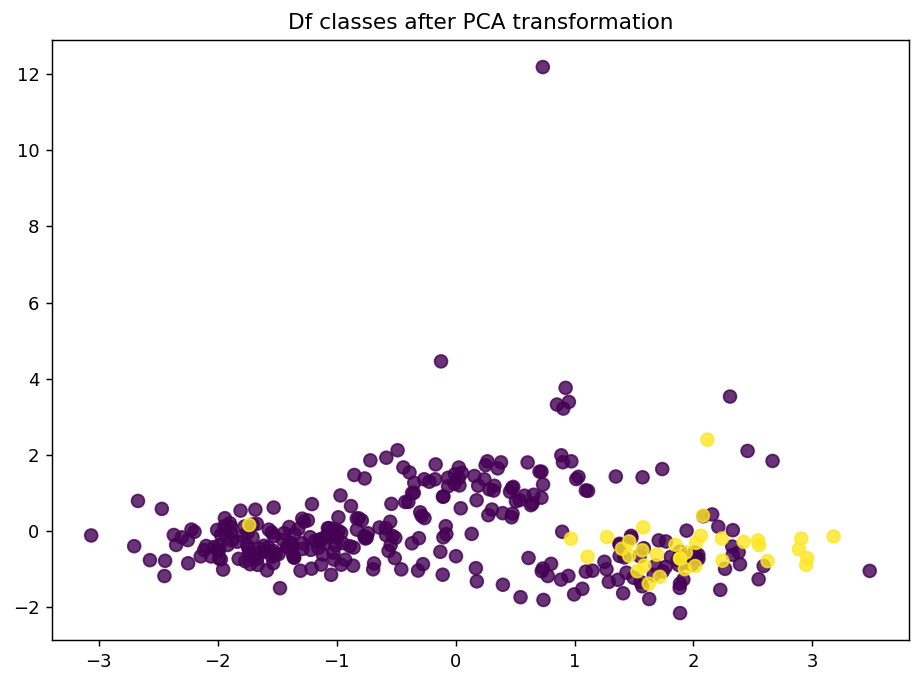

In [26]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Isolate the data we'll need for plotting.
x_component, y_component = transformed_df[:, 0], transformed_df[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50, alpha=8/10)
plt.title('Df classes after PCA transformation')
plt.show()

In [27]:
# Dataset spliting
from sklearn.model_selection import train_test_split
from collections import Counter

TEST_SIZE = 0.2
INITIAL_TRAIN_SIZE = 0.1

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=TEST_SIZE, random_state=RANDOM_STATE_SEED, shuffle=True, stratify=y_raw)

print("Train dataset:")
print(f"{len(y_train)} samples")
print(f"{Counter(y_train)}")

print("Test dataset:")
print(f"{len(y_test)} samples")
print(f"{Counter(y_test)}")

# Initial train and pool split
X_train_init, X_pool, y_train_init, y_pool = train_test_split(X_train, y_train, train_size=INITIAL_TRAIN_SIZE, random_state=RANDOM_STATE_SEED, shuffle=True, stratify=y_train)

print("Init train dataset:")
print(f"{len(y_train_init)} samples")
print(f"{Counter(y_train_init)}")

print("Pool dataset:")
print(f"{len(y_pool)} samples")
print(f"{Counter(y_pool)}")

Train dataset:
268 samples
Counter({-1: 240, 1: 28})
Test dataset:
68 samples
Counter({-1: 61, 1: 7})
Init train dataset:
26 samples
Counter({-1: 23, 1: 3})
Pool dataset:
242 samples
Counter({-1: 217, 1: 25})


## Active Learning

In [28]:
# Hyperparameters tunning of the initial model
from sklearn.base import ClassifierMixin
from sklearn.model_selection._search import BaseSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, StratifiedKFold
from config import param_grid

from metrics import f2_score, pr_auc_score


def tune_classifiers_hyperparameters(Clf: ClassifierMixin, X, y, param_grid, GridSearchMethod: BaseSearchCV,  scorer, random_state=13, verbose=True) -> tuple:

    skf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
    # Any GridSearch assumes stratified folds if there is classifier
    if issubclass(GridSearchMethod, GridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=param_grid, scoring=scorer, refit=True, cv=skf)
    elif issubclass(GridSearchMethod, HalvingGridSearchCV):
        gs = GridSearchMethod(estimator=Clf(), param_grid=param_grid, scoring=scorer, refit=True, cv=skf, factor=2)
    else:
        raise ValueError("Unknown or unsupported BaseSearchCV") 
    
    gs.fit(X, y)

    if verbose:
        params_combinations = gs.cv_results_["params"]
        params_combinations_scores = gs.cv_results_["mean_test_score"]
        for i, params in enumerate(params_combinations):
            print(f"{params}\n{params_combinations_scores[i]}")

    return (gs.best_estimator_, gs.best_params_)

In [29]:
# 1. Uncertainty sampling
from sklearn.svm import SVC

# Import active learning classes and methods
import os
import sys
# module_path = os.path.abspath(os.path.join('./active_learning/modAL/'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

Clf = SVC
init_model, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, param_grid[Clf.__name__], GridSearchCV, f2_score, verbose=False)
print(f"Optimal hyperp arameters: {params}")
learner = ActiveLearner(estimator=init_model, query_strategy=uncertainty_sampling)
learner.X_training = X_train_init
learner.y_training = y_train_init

Optimal hyperp arameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}


/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [21]:
# 2.1 Query-by-Committee
from sklearn.svm import SVC
from modAL.models import ActiveLearner, Committee

n_members = 3

Clf = SVC
init_model, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, param_grid[Clf.__name__], GridSearchCV, f2_score, verbose=False)
print(f"Optimal hyperparameters: {params}")

learners = []
for _ in range(n_members):
    learner = ActiveLearner(
            estimator = init_model
        )
    learner.X_training = X_train_init
    learner.y_training = y_train_init
    learners.append(learner)

from modAL.disagreement import vote_entropy_sampling

committee = Committee(
    learner_list = learners,
    query_strategy = vote_entropy_sampling
)

learner = committee

Optimal hyperparameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}


/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [9]:
# 2.2 Query-by-Bagging
import numpy as np

# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 121
np.random.seed(RANDOM_STATE_SEED)

n_members = 9
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()
from modAL import ActiveLearner
from modAL import Committee
from sklearn.svm import SVC
Clf = SVC
init_model, params = tune_classifiers_hyperparameters(Clf, X_train_init, y_train_init, param_grid[Clf.__name__], GridSearchCV, f2_score, verbose=False)
print(f"Optimal hyperparameters: {params}")

learners = []
for _ in range(n_members):
    learner = ActiveLearner(
            estimator = init_model,
            X_training = X_train_init, y_training = y_train_init,
            bootstrap_init = True,
            stratify=True
        )
    learners.append(learner)

from modAL.disagreement import max_disagreement_sampling

committee = Committee(
    learner_list = learners,
    query_strategy = max_disagreement_sampling
)

learner = committee

# AFTER RELEARNING WITH ONE ADDITIONAL SAMPLE USE REBAGGING OR BOOTSTRAP ON TEACH!

Optimal hyperparameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}


/Users/wojciechrokicki/Documents/Magister/praca_magisterska/active-learning-analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
# 2.3 Query-by-Boosting TODO

In [12]:
# 3. Expected Model Change TODO - probably use bayesian optimization - expected model improvement

In [8]:
# 4. Expected Error Reduction
from sklearn.naive_bayes import GaussianNB

# Import active learning classes and methods
import os
import sys
module_path = os.path.abspath(os.path.join('./active_learning/modAL/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from modAL.models import ActiveLearner
from modAL.expected_error import expected_error_reduction

svc = GaussianNB()
learner = ActiveLearner(estimator=svc, query_strategy=expected_error_reduction, X_training=X_train_init, y_training=y_train_init)

In [14]:
# 5. Variance Reduction
# from modAL.decorators import change_repr
from sklearn.base import BaseEstimator
from modAL.utils.data import modALinput

from modAL.utils.selection import (multi_argmin, shuffled_argmin)

from numpy.linalg import LinAlgError

# @change_repr
def fisher_information_sampling(classifier: BaseEstimator, X: modALinput,
                    n_instances: int = 1, random_tie_break: bool = False,
                    **uncertainty_measure_kwargs) -> np.ndarray:
    """
    Fisher Information sampling query strategy. Selects the instances which influences the sensitivity of the model's likelihood function with respect to the model parameters least.
    Args:
        classifier: The classifier for which the labels are to be queried.
        X: The pool of samples to query from.
        n_instances: Number of samples to be queried.
        random_tie_break: If True, shuffles utility scores to randomize the order. This
            can be used to break the tie when the highest utility score is not unique.
        **uncertainty_measure_kwargs: Keyword arguments to be passed for the uncertainty
            measure function.
    Returns:
        The indices of the instances from X chosen to be labelled.
        The margin metric of the chosen instances.
    """

    probabilities = classifier.predict_proba(X, **uncertainty_measure_kwargs)
    W_x = np.diag(np.prod(probabilities, axis=1))
    I_u = np.linalg.multi_dot([X.T, W_x, X])

    fi = []
    for i in range(W_x.shape[0]):
        I_x = np.outer((X[i]*W_x[i,i]), X[i])
        try:
            inv_I_x = np.linalg.inv(I_x)
        except LinAlgError:
            inv_I_x = np.linalg.pinv(I_x) # or other options such as: dropping the sample (singularity means low sensitivity of the model to that sample); regularization (adding small positive values to the diagonal of the initial matrix to stabilize the calculations); pseudo-inverse (this situation - it exists for all matrices)
        tr = np.trace(np.linalg.multi_dot([I_u, inv_I_x]))
        fi.append(tr)

    fi = np.array(fi)

    if not random_tie_break:
        return multi_argmin(fi, n_instances=n_instances)

    return shuffled_argmin(fi, n_instances=n_instances)

from sklearn.linear_model import LogisticRegression

# Import active learning classes and methods
import os
import sys
module_path = os.path.abspath(os.path.join('./active_learning/modAL/'))
if module_path not in sys.path:
    sys.path.append(module_path)

from modAL.models import ActiveLearner

logistic_regressor = LogisticRegression(penalty=None, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=RANDOM_STATE_SEED, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
learner = ActiveLearner(estimator=logistic_regressor, query_strategy=fisher_information_sampling, X_training=X_train_init, y_training=y_train_init)

In [15]:
# 6. Density-weighted methods

In [16]:
# 7. Class weights

In [30]:
from metrics import method_eval

VERBOSE = 1

# Evaluate model trained on the whole data
model = SVC(**params)
# model = LogisticRegression(penalty=None, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=RANDOM_STATE_SEED, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
# model = GaussianNB()
# model = RandomForestClassifier()
model.fit(X_train, y_train) # TODO: Should it be hypertunned on whole train? No, there should be fair comparison
y_pred = model.predict(X_test)

print("Full dataset model")
print(50*'-')
full_model_score = method_eval(y_test=y_test, y_pred=y_pred, verbose=VERBOSE)
print(50*'-')

# Evaluate initial model
y_pred = learner.predict(X_test)

print("Initial model")
print(50*'-')
unqueried_score = method_eval(y_test=y_test, y_pred=y_pred, verbose=VERBOSE)
print(50*'-')

Full dataset model
--------------------------------------------------
accuracy: 0.8823529411764706,
precision: 0.4666666666666667,
recall: 1.0,
f2_score: 0.813953488372093,
auc_pr_curve: 0.7333333333333334,
auc_roc_curve: 0.9344262295081966
--------------------------------------------------
Initial model
--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
recall: 1.0,
f2_score: 0.8333333333333334,
auc_pr_curve: 0.75,
auc_roc_curve: 0.9426229508196721
--------------------------------------------------


In [31]:
# Metrics for tracking active learning process
CHANGE_WINDOW_SIZE = 10
MEAN_ABS_DIFF_THRESHOLD = 0.05

def calculate_mean_abs_difference(X, Y):
    return np.mean(np.abs(X-Y))

In [20]:
##############################
# Pool based active learning #
##############################
from modAL.uncertainty import classifier_entropy
import copy

learner_al = copy.deepcopy(learner)
X_pool_al, y_pool_al = copy.deepcopy(X_pool), copy.deepcopy(y_pool)

# Pool based active learning configuration
AL_QUERY_BATCH_SIZE = 1

# Stopping criterion configuration
from enum import Enum
class StoppingCriterion(Enum):
  N_QUERIES = 1
  ENTROPY_CONFIDENCE = 2

STOPPING_CRITERION = StoppingCriterion.N_QUERIES
# STOPPING_CRITERION = StoppingCriterion.ENTROPY_CONFIDENCE

match STOPPING_CRITERION.name:
  case "N_QUERIES":
    N_QUERIES = 50
    # Check N_QUERIES TODO: using as many samples as it can and only warning (?)
    if N_QUERIES * AL_QUERY_BATCH_SIZE > len(y_pool_al):
      raise ValueError(f"The pool samples size ({len(y_pool_al)}) is to small for requested number of queries ({N_QUERIES * AL_QUERY_BATCH_SIZE}). Decrease N_QUERIES or AL_QUERY_BATCH_SIZE.")
  case "ENTROPY_CONFIDENCE":
    N_QUERIES = X_pool_al.shape[0]
    N_DECLINE_ROUNDS = 5
    n_decline_rounds = 0

if AL_QUERY_BATCH_SIZE > len(y_pool_al):
      raise ValueError(f"The batch size is too big!")


# Those are sanity checks, so they are supposed to be used for code assumptions, not for user inputs checks
# assert solver == "liblinear", ("message")

# AL statistics
queried_classes_counter = Counter()
performance_history = [unqueried_score]
initial_confidence = np.mean(classifier_entropy(learner_al, X_test))
entropy_confidence_history = [initial_confidence]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner_al.query(X_pool_al, n_instances=AL_QUERY_BATCH_SIZE)

  print(f"{index+1}. iteration: Chosen sample was of a class: {y_pool_al[query_index]}")
  queried_classes_counter.update(y_pool_al[query_index])

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool_al[query_index], y_pool_al[query_index]
  learner_al.teach(X=X, y=y)
  # learner_al.teach(X=X, y=y, bootstrap=True, stratify=True) # for Query-By-Bagging


  # Remove the queried instance from the unlabeled pool.
  X_pool_al, y_pool_al = np.delete(X_pool_al, query_index, axis=0), np.delete(y_pool_al, query_index)

  # Calculate and report our model's accuracy.
  y_pred = learner_al.predict(X_test)
  print(50*'-')
  model_accuracy = method_eval(y_test=y_test, y_pred=y_pred, verbose=VERBOSE)
  print(50*'-')

  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

  # Check al process change
  if index + 2 > CHANGE_WINDOW_SIZE:
    metrics = list(zip(*[x.values() for x in performance_history]))    
    a = metrics[0][-(CHANGE_WINDOW_SIZE+1):-1]
    b = metrics[0][-CHANGE_WINDOW_SIZE:]
    print(a,b)
    mean_abs_diff = calculate_mean_abs_difference(np.array(b), np.array(a))
    if mean_abs_diff < MEAN_ABS_DIFF_THRESHOLD:
      print("WARNING: Model is not improving!")

  # Entropy confidence
  entropy_confidence_history.append(np.mean(classifier_entropy(learner_al, X_test)))
  if STOPPING_CRITERION.name == "ENTROPY_CONFIDENCE":
    if entropy_confidence_history[-1] < entropy_confidence_history[-2]:
      n_decline_rounds += 1
    else:
      n_decline_rounds = 0
    if n_decline_rounds >= N_DECLINE_ROUNDS:
      break
    if len(y_pool_al) < AL_QUERY_BATCH_SIZE:
      break
    

print(f"Queried samples:\n {queried_classes_counter}")
n_queries = sum(queried_classes_counter.values())
print(f"{len(y_train_init) + n_queries} out of {len(y_train)} samples seen.")

1. iteration: Chosen sample was of a class: [-1]
--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
recall: 1.0,
f2_score: 0.8333333333333334,
auc_pr_curve: 0.75,
auc_roc_curve: 0.9426229508196721
--------------------------------------------------
2. iteration: Chosen sample was of a class: [1]
--------------------------------------------------
accuracy: 0.8970588235294118,
precision: 0.5,
recall: 1.0,
f2_score: 0.8333333333333334,
auc_pr_curve: 0.75,
auc_roc_curve: 0.9426229508196721
--------------------------------------------------
3. iteration: Chosen sample was of a class: [-1]
--------------------------------------------------
accuracy: 0.8823529411764706,
precision: 0.46153846153846156,
recall: 0.8571428571428571,
f2_score: 0.7317073170731707,
auc_pr_curve: 0.6666936005171299,
auc_roc_curve: 0.8711943793911008
--------------------------------------------------
4. iteration: Chosen sample was of a class: [1]
--------------------------

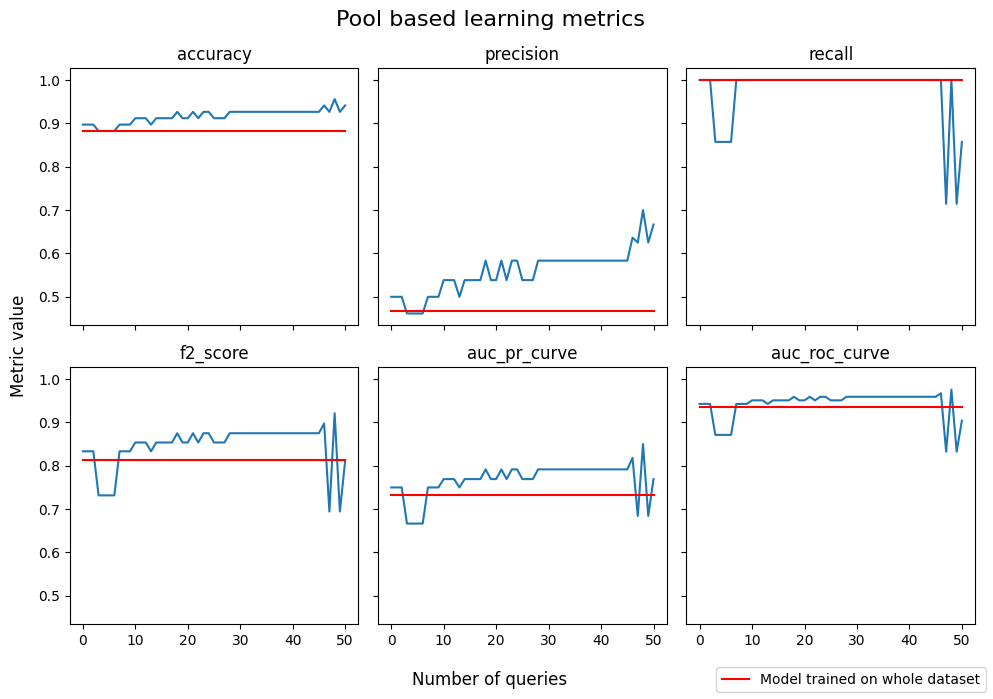

In [32]:
# Plotting metrics
fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex=True, sharey=True)

if type(full_model_score) is not list:
    full_model_score = list(full_model_score.values())
metrics = list(zip(*[x.values() for x in performance_history]))

for i, metric_name in enumerate(performance_history[0].keys()):
    axs[int(i/3), int(i%3)].plot(range(len(metrics[i])), metrics[i])
    handle = axs[int(i/3), int(i%3)].plot(range(len(metrics[i])), np.ones(len(metrics[i]))*full_model_score[i], "r")
    axs[int(i/3), int(i%3)].set_title(metric_name)

fig.suptitle("Pool based learning metrics", fontsize=16)
fig.supxlabel("Number of queries")
fig.supylabel("Metric value")
fig.legend(handle, ["Model trained on whole dataset"], loc='lower right')
fig.tight_layout()

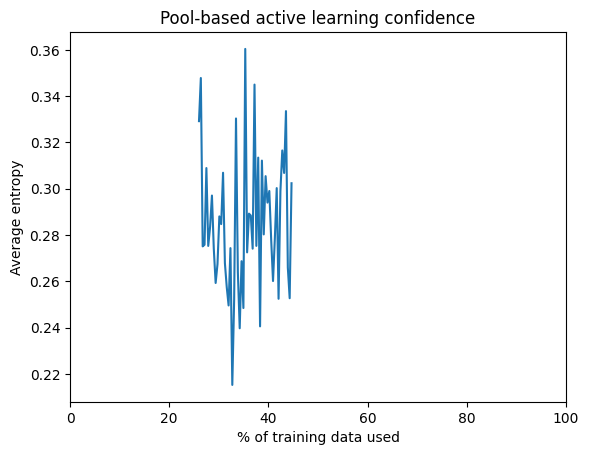

In [15]:
# Plot the confidence
x_train_usage = [i*AL_QUERY_BATCH_SIZE/len(y_train)*100+len(y_train_init) for i in range(len(entropy_confidence_history))]
plt.plot(x_train_usage, entropy_confidence_history)
plt.title("Pool-based active learning confidence")
plt.xlabel(r'% of training data used')
plt.ylabel('Average entropy')
plt.xlim(left=0, right=100)
plt.show()

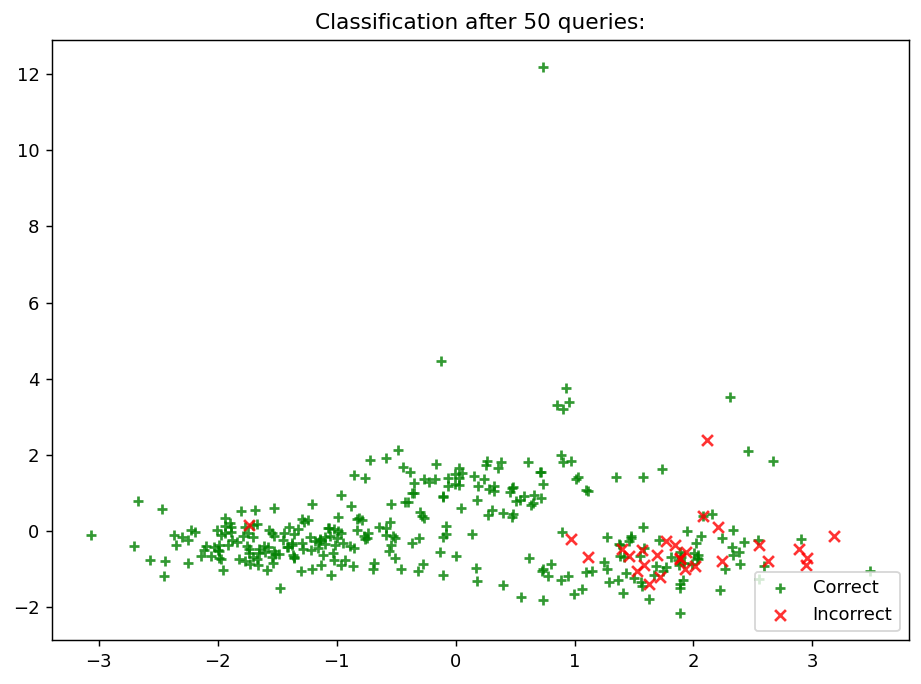

In [17]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title(f'Classification after {N_QUERIES} queries:')
ax.legend(loc='lower right')

plt.show()

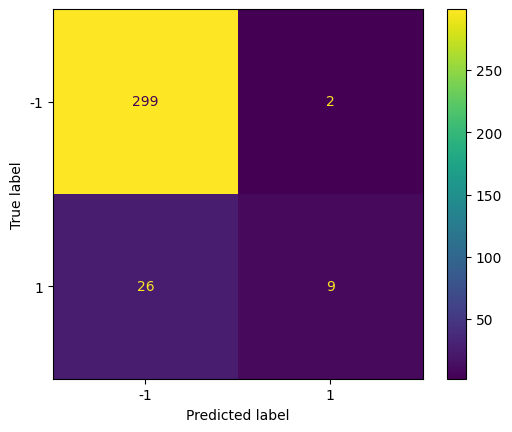

Counter({-1: 325, 1: 11})


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if not issubclass(learner.__class__, Committee):
    classes = learner.estimator.classes_
else:
    classes = learner.classes_

cm = confusion_matrix(y_raw, predictions, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot()
plt.show()

print(f"{Counter(predictions)}")